# Calculate a seed based correlation using nilearn

This script calculates a seed based correlation as implemented in nilearn. Seeds are specified using coordinates and labels.

In [8]:
%matplotlib inline
import nilearn
from nilearn import datasets
import matplotlib.pyplot as plt
import numpy as np

### Load the data

Load the adhd dataset from the nilearn data fetcher.

The phenotypic data won't be needed here. 

In [2]:
adhd_dataset = nilearn.datasets.fetch_adhd(n_subjects=1)

func_filename = adhd_dataset.func[0] # Need to specify the subject you want, otherwise you will get the whole list.
confound_filename = adhd_dataset.confounds[0]

Set coordinates where the times series should be extracted. In this example we'll use the Posterior Cingulate Cortex coordinate, which is part of the default mode network. It will also work with more than one seed. To plot them, however, you need to specify two plots individually plot them in a loop.

In [40]:
dmn_coords = [(0, -52, 18), (-46, -68, 32)]
labels = [
    'Posterior Cingulate Cortex',
    'Left Temporoparietal junction'
]

Extract time series from seeds.



In [41]:
from nilearn import input_data

seed_masker = input_data.NiftiSpheresMasker(
    dmn_coords, radius=8,
    detrend=True, standardize=True,     # Calculate z-score with mean 0.
    low_pass=0.1, high_pass=0.01, t_r=2,
    memory='nilearn_cache', memory_level=1, verbose=0)
# Since we specifie the cache (memory), the stuff that was already run won't need to run again.

seed_time_series = seed_masker.fit_transform(func_filename,
                                   confounds=[confound_filename])

/home/glad/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/func_inspect.py:191: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  arg_spec = inspect.getargspec(func)
/home/glad/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/func_inspect.py:191: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  arg_spec = inspect.getargspec(func)
/home/glad/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/func_inspect.py:191: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  arg_spec = inspect.getargspec(func)


Plot the time series and calculate the standard deviation.

1.0

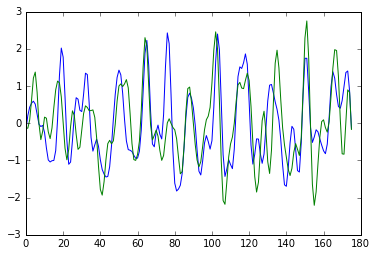

In [42]:
plt.plot(seed_time_series)
np.std(seed_time_series)

Extract the whole brain signal.

First we'll run it without a mask, i.e. with an implicit mask. The calculation will be done based on the EPI data, thus the background will be masked.

In [43]:
brain_masker = input_data.NiftiMasker(
    smoothing_fwhm=6,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2,
    verbose=0)

brain_time_series = brain_masker.fit_transform(func_filename,
                                   confounds=[confound_filename])


In [44]:
# This should show you the number of volumes x number of voxels.
brain_time_series.shape

(176, 69681)

Calculate seed based correlation. We'll do it with `numpy` by calculating the dot-product. Make sure the inner dimensions are the same, hence the need to transpose the first variable with `.T`. The result is a vector. The dot product is divided by the number of volumes s.t. the values are between -1 and 1.

In [45]:
seed_based_correlations = np.dot(brain_time_series.T,seed_time_series)/seed_time_series.shape[0]

In [46]:
seed_based_correlations.shape # What does the vector look like?

(69681, 2)

In [47]:
print(seed_based_correlations.min(),seed_based_correlations.max()) # Min and max values from vector.

-0.715457009996 0.971725906095


([array([   230.,   2892.,  10040.,  19529.,  20543.,  11294.,   3823.,
           1014.,    257.,     59.]),
  array([    60.,   2148.,   9429.,  21169.,  20822.,  10471.,   3853.,
           1329.,    338.,     62.])],
 array([-0.71545701, -0.54673872, -0.37802043, -0.20930214, -0.04058384,
         0.12813445,  0.29685274,  0.46557103,  0.63428932,  0.80300761,
         0.97172591]),
 <a list of 2 Lists of Patches objects>)

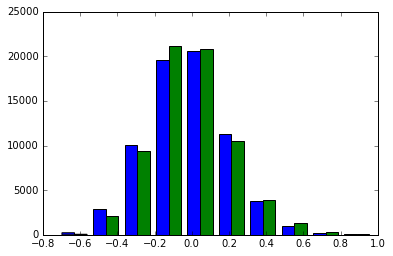

In [48]:
plt.hist(seed_based_correlations) # Plot the histogram of the seed based correlation.

Let's transform the vector into a 3D Nifti image object with header, etc. It needs to be transposed since .inverse_transform wants a [1,N] vector.

In [49]:
seed_based_corr_img = brain_masker.inverse_transform(seed_based_correlations.T)

Plot the statistical map thresholded at a specific value. Then plot the connectome with the chosen seed. For the adjacency matrix you need an [x,y] matrix. `np.atleast_2d` specifies such an array.

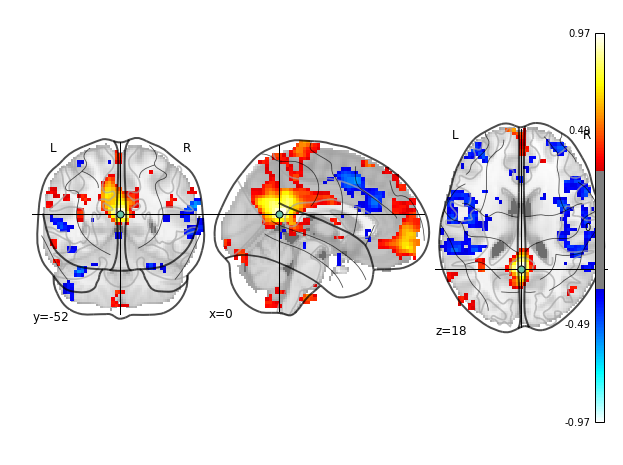

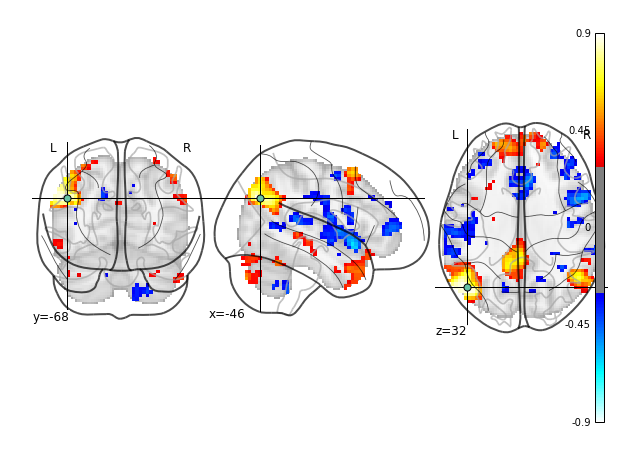

In [64]:
from nilearn import plotting

for img in range(len(labels)):    
    figure = plt.figure(figsize=(8,6))
    plotting.plot_stat_map(nilearn.image.index_img(seed_based_corr_img, img), threshold=0.3, figure=figure, cut_coords=dmn_coords[img])
    plotting.plot_connectome(node_coords=np.atleast_2d(dmn_coords[img]), figure=figure, adjacency_matrix=np.atleast_2d([1]))

In [ ]:
figure = plt.figure()
plotting.plot_stat_map(seed_based_corr_img, threshold=0.3, figure=figure, cut_coords=dmn_coords[0])
